In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Flatten, Dense, Conv2D
import cv2
import numpy as np
import pandas as pd
import os

# Load the images
def load_areas_from_csv(csv_file):
    # Read csv file into a DataFrame
    df = pd.read_csv(csv_file, header=None, names=["filename", "area"], dtype={"area": np.float32})
    # Convert DataFrame into a dictionary
    areas = dict(zip(df.filename, df.area))
    return areas

def load_images_and_areas(folder, csv_file):
    images = list()
    true_areas = list()
    areas = load_areas_from_csv(csv_file)
    for filename in sorted(os.listdir(folder)):
        img = cv2.imread(os.path.join(folder,filename))
        img = cv2.resize(img, (224, 224)) #resize
        if filename in areas.keys() and img is not None: #add true values and images based on index to a list
            images.append(img)
            true_areas.append(areas[filename])
    return images, true_areas
#load data
images, true_areas = load_images_and_areas('/content/drive/MyDrive/Computational imaging/jpeg_images', '/content/Leaf scan anaylsis AMF experiment.csv')

In [6]:
#data splitting
from sklearn.model_selection import train_test_split
images = np.array(images)
true_areas = np.array(true_areas)

images_train, images_val, true_areas_train, true_areas_val = train_test_split(images, true_areas, test_size=0.2, random_state=42)

In [13]:
#Model 1
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, LeakyReLU
from tensorflow.keras.callbacks import ModelCheckpoint

def get_model():
    # Load the pre-trained model, excluding the top layers
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers:
      layer.trainable = False

    # Define new model
    model = tf.keras.Sequential([
        base_model,
        Conv2D(128, (3, 3), activation='relu'),
        Conv2D(64, (3, 3), activation='relu'),
        Conv2D(32, (3, 3), activation='relu'),
        Flatten(),
        Dense(128, activation='linear'),
        Dense(1)
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mean_squared_error', metrics=['mae'])

    return model
checkpoint = ModelCheckpoint(filepath='/content/model1/model.{epoch:02d}-{val_loss:.2f}.h5',
                             monitor='val_loss',
                             save_best_only=True,
                             mode='auto',
                             verbose=1)

model1 = get_model()
model1.summary()
history1 = model1.fit(images_train, true_areas_train,
                    validation_data=(images_val, true_areas_val),
                    epochs=100,
                    callbacks=[checkpoint])  # Pass callback to training


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 conv2d_9 (Conv2D)           (None, 5, 5, 128)         2359424   
                                                                 
 conv2d_10 (Conv2D)          (None, 3, 3, 64)          73792     
                                                                 
 conv2d_11 (Conv2D)          (None, 1, 1, 32)          18464     
                                                                 
 flatten_3 (Flatten)         (None, 32)                0         
                                                                 
 dense_6 (Dense)             (None, 128)               4224      
                                                                 
 dense_7 (Dense)             (None, 1)                

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 16s 2s/step - loss: 1105.1110 - mae: 27.7903 - val_loss: 159.3381 - val_mae: 11.4371
Epoch 2/100
3/4 [=====================>........] - ETA: 0s - loss: 460.9694 - mae: 20.3588
Epoch 2: val_loss did not improve from 159.33810
4/4 [==============================] - 1s 142ms/step - loss: 464.6265 - mae: 20.4803 - val_loss: 421.0129 - val_mae: 19.7803
Epoch 3/100
3/4 [=====================>........] - ETA: 0s - loss: 493.3118 - mae: 21.3350
Epoch 3: val_loss improved from 159.33810 to 75.80895, saving model to /content/model1/model.03-75.81.h5
4/4 [==============================] - 1s 355ms/step - loss: 478.2082 - mae: 20.8779 - val_loss: 75.8090 - val_mae: 7.1952
Epoch 4/100
3/4 [=====================>........] - ETA: 0s - loss: 83.5706 - mae: 7.1573
Epoch 4: val_loss did not improve from 75.80895
4/4 [==============================] - 0s 116ms/step - loss: 84.7117 - mae: 7.2847 - val_loss: 287.2916 - val_mae: 15.2767
Epoch 5/100
3/4 [===============

In [7]:
#Model2
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, LeakyReLU
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
def get_model2():
    # Load the pre-trained ResNet50 model, excluding the top layers
    # Base layers are trainable
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers:
        layer.trainable = True

    # Define second model with leaky relu
    model = Sequential([
        base_model,
        Conv2D(128, (3, 3)),
        LeakyReLU(alpha=0.01),
        Conv2D(64, (3, 3)),
        LeakyReLU(alpha=0.01),
        Conv2D(32, (3, 3)),
        LeakyReLU(alpha=0.01),
        Flatten(),
        Dense(128),
        LeakyReLU(alpha=0.01),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

    return model

# Callback that saves the model's weights
checkpoint = ModelCheckpoint(filepath='/content/model2/model.{epoch:02d}-{val_loss:.2f}.h5',
                             monitor='val_loss',
                             save_best_only=True,
                             mode='auto',
                             verbose=1)

#Reducing learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)



model2 = get_model2()
model2.summary()
# Trainining
history2 = model2.fit(images_train, true_areas_train,
                    validation_data=(images_val, true_areas_val),
                    epochs=100,
                    callbacks=[checkpoint, reduce_lr])  # Pass callback to training



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 conv2d_6 (Conv2D)           (None, 5, 5, 128)         2359424   
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 5, 5, 128)         0         
                                                                 
 conv2d_7 (Conv2D)           (None, 3, 3, 64)          73792     
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 3, 3, 64)          0         
                                                                 
 conv2d_8 (Conv2D)           (None, 1, 1, 32)          18464     
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 1, 1, 32)         

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 117s 21s/step - loss: 2782.0298 - mae: 40.8617 - val_loss: 337.5582 - val_mae: 17.4121 - lr: 0.0010
Epoch 2/100
4/4 [==============================] - ETA: 0s - loss: 627.3085 - mae: 24.2539 
Epoch 2: val_loss did not improve from 337.55823
4/4 [==============================] - 78s 18s/step - loss: 627.3085 - mae: 24.2539 - val_loss: 484.0988 - val_mae: 21.1856 - lr: 0.0010
Epoch 3/100
4/4 [==============================] - ETA: 0s - loss: 89.7430 - mae: 7.5101 
Epoch 3: val_loss improved from 337.55823 to 74.65302, saving model to /content/model2/model.03-74.65.h5
4/4 [==============================] - 79s 19s/step - loss: 89.7430 - mae: 7.5101 - val_loss: 74.6530 - val_mae: 7.3730 - lr: 0.0010
Epoch 4/100
4/4 [==============================] - ETA: 0s - loss: 61.8925 - mae: 6.3778 
Epoch 4: val_loss did not improve from 74.65302
4/4 [==============================] - 81s 19s/step - loss: 61.8925 - mae: 6.3778 - val_loss: 159.9848 - val_mae: 9.6

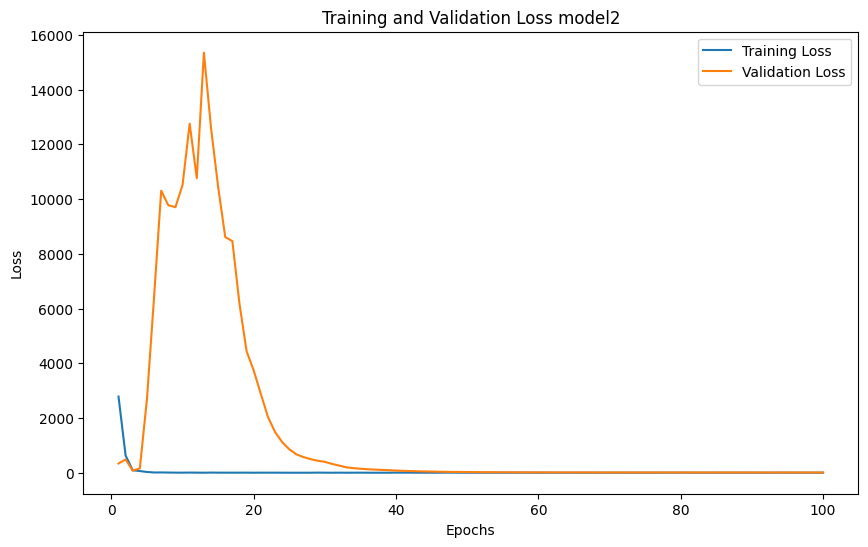

In [8]:
import matplotlib.pyplot as plt
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(1, len(loss) + 1)

# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss model2')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [1]:
import matplotlib.pyplot as plt
loss = history1.history['loss']
val_loss = history1.history['val_loss']
epochs = range(1, len(loss) + 1)

# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and validation loss model1')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

NameError: name 'history1' is not defined

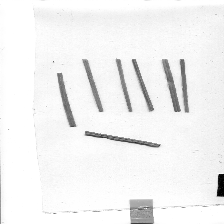

1/1 [==============================] - 2s 2s/step
The model 2 area is: [[11.516606]]
Correct area is 25.64941107


In [11]:
from google.colab.patches import cv2_imshow
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (224, 224))
    cv2_imshow(img)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    return img

new_model2 = tf.keras.models.load_model("/content/model2/model.98-9.38.h5")
img = preprocess_image('/content/drive/MyDrive/Computational imaging/jpeg_images/AMF007.jpg')
predicted_area2 = new_model2.predict(img)
print(f'The model 2 area is: {predicted_area2}')
print(f'Correct area is 25.64941107')

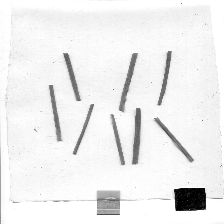

1/1 [==============================] - 1s 940ms/step
The model 1 area is: [[6.813489]]
The model 2 area is: [[18.825739]]
Correct area is 25.64941107


In [28]:
from google.colab.patches import cv2_imshow
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (224, 224))
    cv2_imshow(img)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    return img

new_model1 = tf.keras.models.load_model("/content/model1/model.52-14.26.h5")
new_model2 = tf.keras.models.load_model("/content/model2/model.82-10.88.h5")
img = preprocess_image('/content/drive/MyDrive/Computational imaging/jpeg_images/AMF115.jpg')
predicted_area1 = new_model1.predict(img)
predicted_area2 = new_model2.predict(img)
print(f'The model 1 area is: {predicted_area1}')
print(f'The model 2 area is: {predicted_area2}')
print(f'Correct area is 25.64941107')

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model

# Load ResNet50 model pre-trained on ImageNet
#base_model = ResNet50(weights='imagenet')
base_model = tf.keras.models.load_model("/content/model2/model.82-10.88.h5")

# Load an example image and preprocess it
img_path = '/content/drive/MyDrive/Computational imaging/jpeg_images/AMF115.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# Create a model that outputs the feature maps from the first convolutional layer
layer_name = 'conv2d_6'
intermediate_layer_model = Model(inputs=base_model.input,
                                 outputs=base_model.get_layer(layer_name).output)

# Get the feature maps
intermediate_output = intermediate_layer_model.predict(x)

# Plot the feature maps
def plot_feature_maps(feature_maps, n_cols=8):
    n_features = feature_maps.shape[-1]
    size = feature_maps.shape[1]
    n_rows = n_features // n_cols
    display_grid = np.zeros((size * n_rows, size * n_cols))
    for i in range(n_features):
        x = i // n_cols
        y = i % n_cols
        feature_map = feature_maps[0, :, :, i]
        feature_map -= feature_map.mean()
        feature_map /= feature_map.std()
        feature_map *= 64
        feature_map += 128
        feature_map = np.clip(feature_map, 0, 255).astype('uint8')
        display_grid[x * size : (x + 1) * size, y * size : (y + 1) * size] = feature_map
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_cols, scale * n_rows))
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

plot_feature_maps(intermediate_output)


ValueError: No such layer: conv1_conv. Existing layers are: ['resnet50', 'conv2d_12', 'leaky_re_lu', 'conv2d_13', 'leaky_re_lu_1', 'conv2d_14', 'leaky_re_lu_2', 'flatten_4', 'dense_8', 'leaky_re_lu_3', 'dense_9'].

In [ ]:
import tensorflow as tf
from google.colab import files


export_dir = './saved_model'
tf.saved_model.save(model, export_dir=export_dir)